In [11]:
import torch
import torch.nn as nn
import numpy as np
import torchvision

# Set the data type and properties
DATA_TYPE = 'int8'  # Using 1 byte per element
assert DATA_TYPE in ['int8']

# Function to record input and output size of each layer
def record_in_out_size(m, x, y):
    x = x[0]  # Extract the first tensor (ignore batch dimension)
    m.input_shape = list(x.shape)  # Store input shape
    m.output_shape = list(y.shape)  # Store output shape
    m.input_size = np.prod(m.input_shape[1:]).item()  # Number of elements in input (excluding batch size)
    m.output_size = np.prod(m.output_shape[1:]).item()  # Number of elements in output (excluding batch size)

# Function to add hooks to all layers
def add_io_hooks(m_):
    m_.register_forward_hook(record_in_out_size)  # Register forward hook to store input and output sizes

# Function to estimate memory for generic layers, separating input and output
def estimate_generic(m):
    input_memory = m.input_size
    output_memory = m.output_size
    return input_memory, output_memory

# Function to convert number of elements to kilobytes (KB)
def nelem2kb(n):
    return n / 1024  # Assuming int8 data type (1 byte per element)

# Main function to estimate per-layer memory for AlexNet
def estimate_model_memory(model, x):
    model.eval()
    model.apply(add_io_hooks)  # Apply the hooks to all layers

    with torch.no_grad():
        _ = model(x)  # Perform a forward pass to collect input/output sizes

    memory_input = []
    memory_output = []
    layer_names = []

    # Iterate through each layer in the model and calculate memory components
    for name, layer in model.named_modules():
        if len(list(layer.children())) == 0:  # Only profile leaf layers (no child layers)
            in_mem, out_mem = estimate_generic(layer)
            print(f"Layer: {name} | Input Shape: {layer.input_shape} | Output Shape: {layer.output_shape}")
            print(f"Layer: {name} | Input Memory: {in_mem} elements | Output Memory: {out_mem} elements")
            memory_input.append(in_mem)
            memory_output.append(out_mem)
            layer_names.append(name)  # Store layer name for labeling

    # Convert all memory components to kilobytes
    memory_input_kb = [nelem2kb(m) for m in memory_input]
    memory_output_kb = [nelem2kb(m) for m in memory_output]

    # Calculate combined memory (Input + Output)
    combined_memory_kb = [in_kb + out_kb for in_kb, out_kb in zip(memory_input_kb, memory_output_kb)]

    return combined_memory_kb, memory_output_kb, layer_names

# Create the AlexNet model
net = torchvision.models.alexnet()

# Create a sample input tensor (batch size = 1, channels = 3, height = 224, width = 224)
sample_input = torch.randn(1, 3, 224, 224)

# Estimate the memory usage for AlexNet
combined_memory, output_memory, layer_names = estimate_model_memory(net, sample_input)

# Print the results for debugging
print("\n=== Layer Names ===")
print(layer_names)
print("\n=== Input + Output Memory (KB) ===")
for i, mem in enumerate(combined_memory):
    print(f"{layer_names[i]}: {mem} KB")

print("\n=== Output Memory Only (KB) ===")
for i, mem in enumerate(output_memory):
    print(f"{layer_names[i]}: {mem} KB")


Layer: features.0 | Input Shape: [1, 3, 224, 224] | Output Shape: [1, 64, 55, 55]
Layer: features.0 | Input Memory: 150528 elements | Output Memory: 193600 elements
Layer: features.1 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 55, 55]
Layer: features.1 | Input Memory: 193600 elements | Output Memory: 193600 elements
Layer: features.2 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 27, 27]
Layer: features.2 | Input Memory: 193600 elements | Output Memory: 46656 elements
Layer: features.3 | Input Shape: [1, 64, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.3 | Input Memory: 46656 elements | Output Memory: 139968 elements
Layer: features.4 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.4 | Input Memory: 139968 elements | Output Memory: 139968 elements
Layer: features.5 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 13, 13]
Layer: features.5 | Input Memory: 139968 elements | Output Memory: 32448 elements
Layer: featur

Layer: features.0 | Input Shape: [1, 3, 224, 224] | Output Shape: [1, 64, 55, 55]
Layer: features.0 | Input Memory: 150528 elements | Output Memory: 193600 elements
Layer: features.1 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 55, 55]
Layer: features.1 | Input Memory: 193600 elements | Output Memory: 193600 elements
Layer: features.2 | Input Shape: [1, 64, 55, 55] | Output Shape: [1, 64, 27, 27]
Layer: features.2 | Input Memory: 193600 elements | Output Memory: 46656 elements
Layer: features.3 | Input Shape: [1, 64, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.3 | Input Memory: 46656 elements | Output Memory: 139968 elements
Layer: features.4 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 27, 27]
Layer: features.4 | Input Memory: 139968 elements | Output Memory: 139968 elements
Layer: features.5 | Input Shape: [1, 192, 27, 27] | Output Shape: [1, 192, 13, 13]
Layer: features.5 | Input Memory: 139968 elements | Output Memory: 32448 elements
Layer: featur

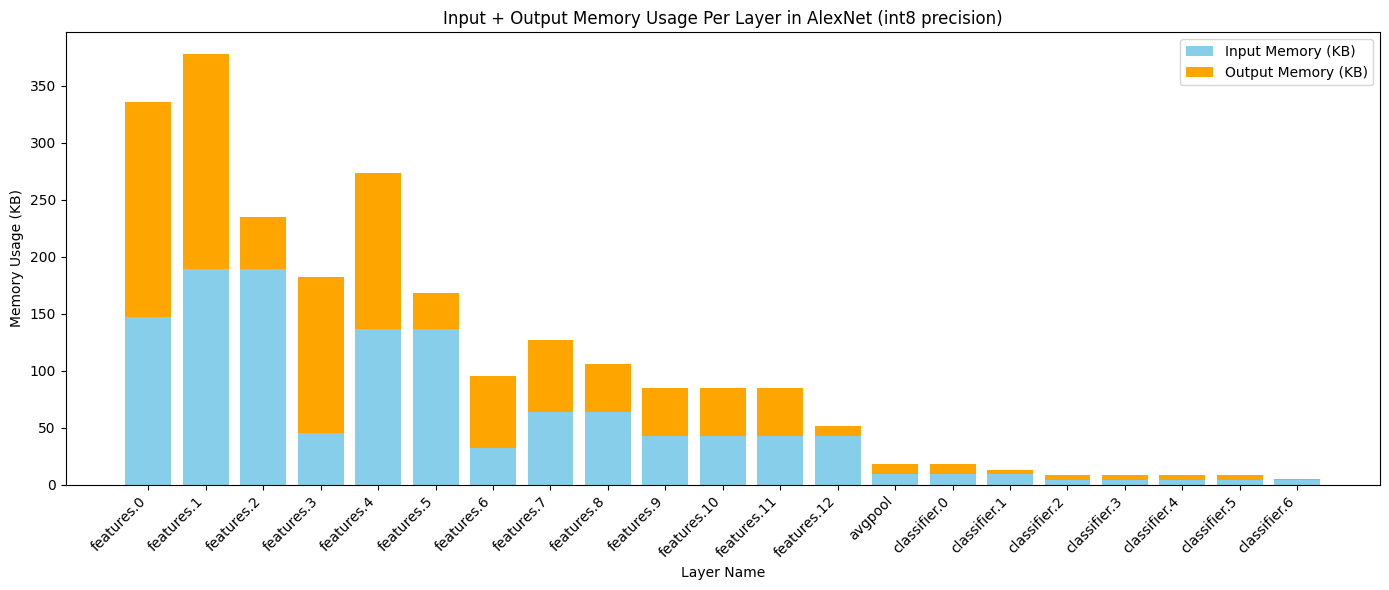

In [15]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt

# Set the data type and properties
DATA_TYPE = 'int8'  # Change to 'fp' for float32 if needed
assert DATA_TYPE in ['int8', 'fp']

# Function to record input and output size of each layer
def record_in_out_size(m, x, y):
    x = x[0]  # Extract the first tensor (ignore batch dimension)
    m.input_shape = list(x.shape)  # Store input shape
    m.output_shape = list(y.shape)  # Store output shape
    m.input_size = np.prod(m.input_shape[1:]).item()  # Number of elements in input (excluding batch size)
    m.output_size = np.prod(m.output_shape[1:]).item()  # Number of elements in output (excluding batch size)

# Function to add hooks to all layers
def add_io_hooks(m_):
    m_.register_forward_hook(record_in_out_size)  # Register forward hook to store input and output sizes

# Function to estimate memory for generic layers, separating input and output
def estimate_generic(m):
    input_memory = m.input_size
    output_memory = m.output_size
    return input_memory, output_memory

# Function to convert number of elements to kilobytes (KB)
def nelem2kb(n, data_type):
    # Convert elements to memory size based on precision type
    element_size = 1 if data_type == 'int8' else 4  # 1 byte for int8, 4 bytes for float32
    return n * element_size / 1024  # Convert to KB

# Main function to estimate per-layer memory for AlexNet
def estimate_model_memory(model, x, data_type):
    model.eval()
    model.apply(add_io_hooks)  # Apply the hooks to all layers

    with torch.no_grad():
        _ = model(x)  # Perform a forward pass to collect input/output sizes

    memory_input = []
    memory_output = []
    layer_names = []

    # Iterate through each layer in the model and calculate memory components
    for name, layer in model.named_modules():
        if len(list(layer.children())) == 0:  # Only profile leaf layers (no child layers)
            in_mem, out_mem = estimate_generic(layer)
            print(f"Layer: {name} | Input Shape: {layer.input_shape} | Output Shape: {layer.output_shape}")
            print(f"Layer: {name} | Input Memory: {in_mem} elements | Output Memory: {out_mem} elements")
            memory_input.append(in_mem)
            memory_output.append(out_mem)
            layer_names.append(name)  # Store layer name for labeling

    # Convert all memory components to kilobytes based on data type
    memory_input_kb = [nelem2kb(m, data_type) for m in memory_input]
    memory_output_kb = [nelem2kb(m, data_type) for m in memory_output]

    return memory_input_kb, memory_output_kb, layer_names

# Create the AlexNet model
net = torchvision.models.alexnet()

# Create a sample input tensor (batch size = 1, channels = 3, height = 224, width = 224)
sample_input = torch.randn(1, 3, 224, 224)

# Estimate the memory usage for AlexNet
memory_input, memory_output, layer_names = estimate_model_memory(net, sample_input, DATA_TYPE)

# Calculate combined memory (Input + Output) for stacked bars
combined_memory_kb = [in_kb + out_kb for in_kb, out_kb in zip(memory_input, memory_output)]

# Plotting a single figure with both Input and Output memory represented in a stacked bar
plt.figure(figsize=(14, 6))
bar1 = plt.bar(layer_names, memory_input, color='skyblue', label='Input Memory (KB)')
bar2 = plt.bar(layer_names, memory_output, bottom=memory_input, color='orange', label='Output Memory (KB)')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Layer Name")
plt.ylabel("Memory Usage (KB)")
plt.title(f"Input + Output Memory Usage Per Layer in AlexNet ({DATA_TYPE} precision)")
plt.legend()
plt.tight_layout()
plt.show()
